In [3]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()



# darksoulnyx
# 734a7af16d9bef7469e2853f8fb9b0cb

Kaggle credentials set.
Kaggle credentials successfully validated.


In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

darksoulnyx_meduloblastoma_path = kagglehub.dataset_download('darksoulnyx/meduloblastoma')

print('Data source import complete.')


100%|██████████| 499M/499M [00:17<00:00, 30.3MB/s]

Extracting files...


Data source import complete.


In [5]:
# prompt: Can you save the above dataset downloaded from kaggle to local directory

import os

# Specify the local directory where you want to save the data.
local_directory = '/content/meduloblastoma_data'  # Change this to your desired directory.

# Create the directory if it doesn't exist.
if not os.path.exists(local_directory):
  os.makedirs(local_directory)

# Move the downloaded data to the local directory.
!mv {darksoulnyx_meduloblastoma_path} {local_directory}

print(f"Dataset saved to: {local_directory}")

Dataset saved to: /content/meduloblastoma_data


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [7]:
# Configuration Parameters
NOISE_DIM = 128               # or 100
BATCH_SIZE = 128               # Try increasing to 64 if hardware allows
STEPS_PER_EPOCH = 1000
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 256, 256, 3

# Optimizer with Learning Rate Scheduling
initial_learning_rate = 0.0002
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)
OPTIMIZER = Adam(learning_rate=lr_schedule, beta_1=0.5)

gp_weight = 10.0
d_steps = 5  # Train discriminator 5 times per generator step


In [8]:
MAIN_DIR = "/content/meduloblastoma_data/1/final_database/100x"

In [9]:
# Paths for saving progress
checkpoint_dir = "./checkpoints"
image_dir = "./generated_images"
log_dir = "./logs"

# Ensure directories exist
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(image_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)


# Loading and Preprocessing the Images

In [10]:
import os
import cv2
import numpy as np

# Define image preprocessing function
def preprocess_images(folder_path, width=256, height=256, channels=3):

    images = []
    # Corrected indentation for the loop
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            # Load image
            img = cv2.imread(img_path)
            # Convert to RGB if not already 3 channels
            if channels == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Resize image
            img = cv2.resize(img, (width, height))
            # Normalize to [-1, 1] range
            img = (img.astype(np.float32) - 127.5) / 127.5
            # Append to the list
            images.append(img)
        except Exception as e:
            print(f"Error processing image {filename}: {e}")
            continue
    # Convert list of images to a numpy array and reshape
    images = np.array(images)
    images = images.reshape(-1, width, height, channels)
    return images

# Example usage
X_train = preprocess_images(MAIN_DIR)
print("Shape of preprocessed images:", X_train.shape)

Shape of preprocessed images: (158, 256, 256, 3)


## Plotting The Real Images

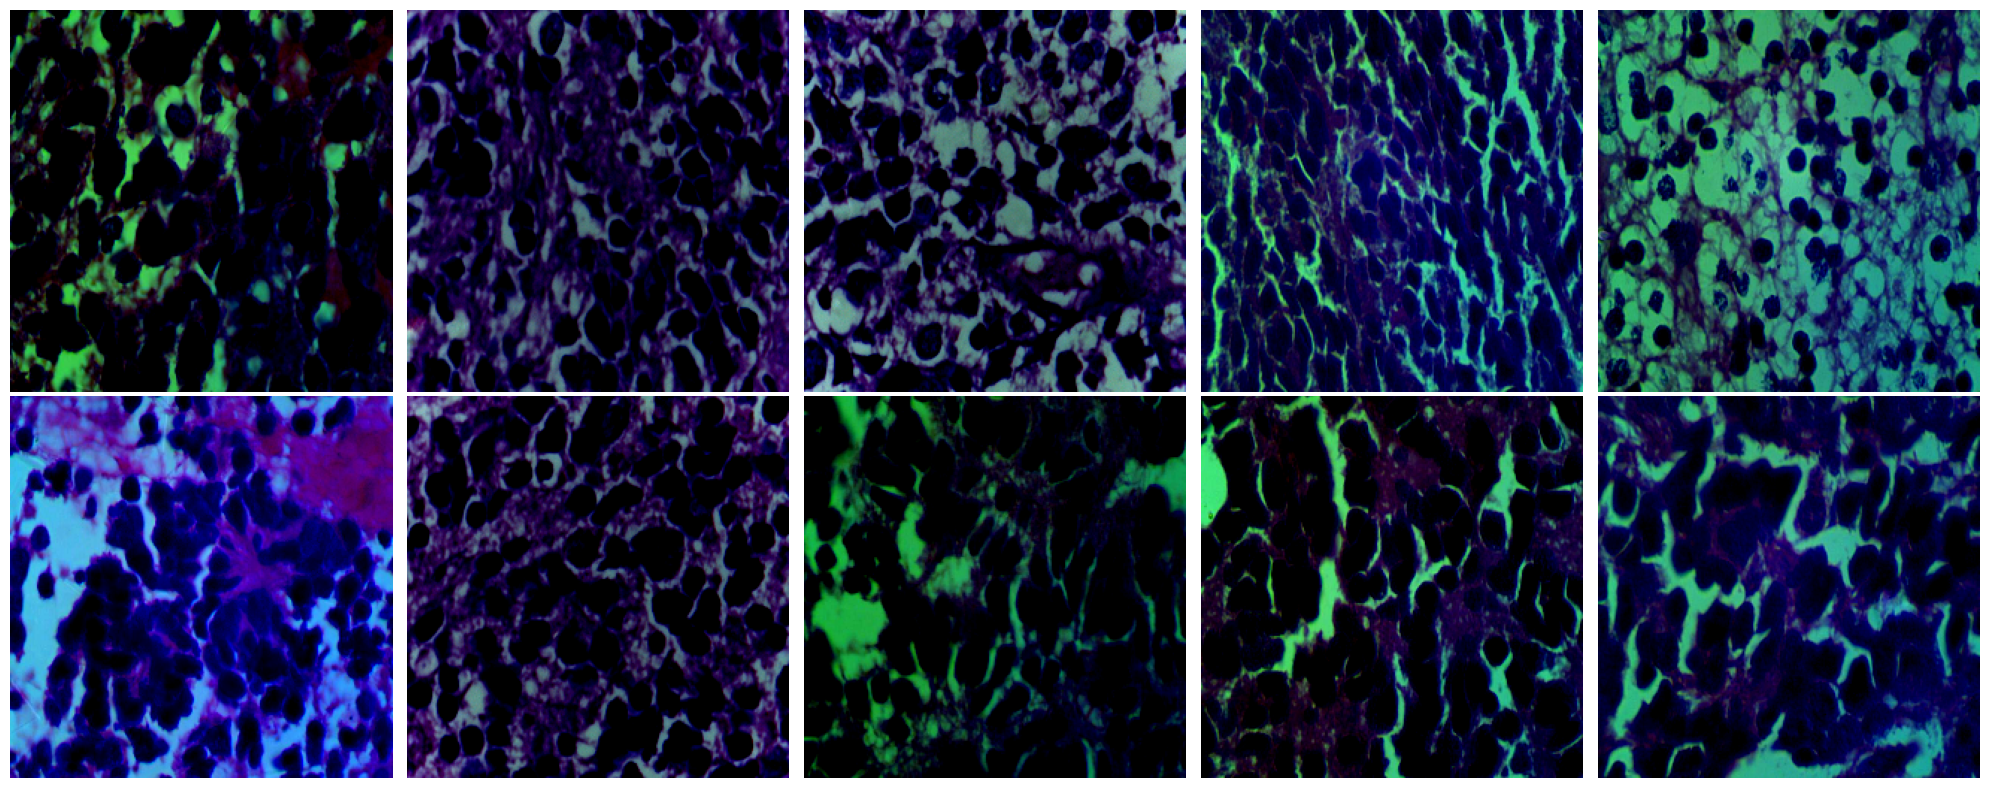

In [ ]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

# The Architecture

In [11]:
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential


In [12]:
# Discriminator Architecture
def build_discriminator():
    model = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Conv2D(256, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Conv2D(512, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Flatten(),
        Dense(1)
    ])
    return model


# Generator Architecture
def build_generator():
    model = Sequential([
        Dense(16 * 16 * 512, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((16, 16, 512)),
        Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh")
    ])
    return model


# Putting it together

In [13]:

generator = build_generator()
discriminator = build_discriminator()




In [14]:
def sample_images(noise, subplots, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)

    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')

        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        if save == True:
            img_name = "gen" + str(i)
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [15]:
def save_sample_images(generator, epoch, batch):
    noise = np.random.normal(0, 1, (10, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = (generated_images * 0.5) + 0.5  # Scale to [0, 1]
    plt.figure(figsize=(10, 4))

    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f"{image_dir}/epoch_{epoch}_batch_{batch}.png")
    plt.close()

## WGAN-Specific Adjustments

In [16]:
from tensorflow.keras import backend as K

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)




In [17]:
import tensorflow as tf

def gradient_penalty(discriminator, real_images, fake_images):
    alpha = tf.random.uniform([BATCH_SIZE, 1, 1, 1], 0.0, 1.0)
    interpolated = alpha * real_images + (1 - alpha) * fake_images
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator(interpolated)
    grads = tape.gradient(pred, [interpolated])[0]
    gp = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((gp - 1.0) ** 2)
    return gp


## The Training

In [18]:
global gen_optimizer, disc_optimizer
gen_optimizer = Adam(learning_rate=lr_schedule, beta_1=0.5) # Assuming lr_schedule is defined
disc_optimizer = Adam(learning_rate=lr_schedule, beta_1=0.5)


In [19]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam

def display_generated_images(generator, epoch, batch):
    """Generate and display sample images."""
    noise = np.random.normal(0, 1, (10, NOISE_DIM))
    generated_images = generator(noise, training=False)
    generated_images = (generated_images * 0.5) + 0.5  # Scale to [0, 1] for display

    plt.figure(figsize=(10, 4))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch + 1}, Batch {batch + 1}", fontsize=16)
    plt.show()
    plt.close()

@tf.function
def train_discriminator(discriminator, generator, real_images, d_steps, gp_weight):
    """Train the discriminator."""
    for _ in range(d_steps):
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        fake_images = generator(noise, training=True)

        with tf.GradientTape() as tape:
            real_pred = discriminator(real_images, training=True)
            fake_pred = discriminator(fake_images, training=True)
            gp = gradient_penalty(discriminator, real_images, fake_images)  # Assuming gradient_penalty is defined
            d_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + gp_weight * gp

        grads = tape.gradient(d_loss, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return d_loss

@tf.function
def train_generator(generator, discriminator):
    """Train the generator."""
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as tape:
        fake_images = generator(noise, training=True)
        fake_pred = discriminator(fake_images, training=True)
        g_loss = -tf.reduce_mean(fake_pred)

    grads = tape.gradient(g_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    return g_loss

def train(generator, discriminator, X_train, epochs, steps_per_epoch,
          d_steps=5, gp_weight=10.0, visualize_interval=500):
    """Train the GAN."""
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        with tqdm(total=steps_per_epoch, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for batch in range(steps_per_epoch):
                # Fetch a batch of real images
                idx = np.random.randint(0, X_train.shape[0], BATCH_SIZE)
                real_images = X_train[idx]

                # Train discriminator and generator
                d_loss = train_discriminator(discriminator, generator, real_images, d_steps, gp_weight)
                g_loss = train_generator(generator, discriminator)

                # Update progress bar
                pbar.set_postfix(D_Loss=d_loss.numpy(), G_Loss=g_loss.numpy())
                pbar.update(1)

                # Display generated images
                if batch % visualize_interval == 0:
                    display_generated_images(generator, epoch, batch)



In [ ]:
epoch = 1


Epoch 1/10


Epoch 1/10:   0%|          | 1/1000 [00:43<11:57:58, 43.12s/batch, D_Loss=-82.9, G_Loss=-94.8]

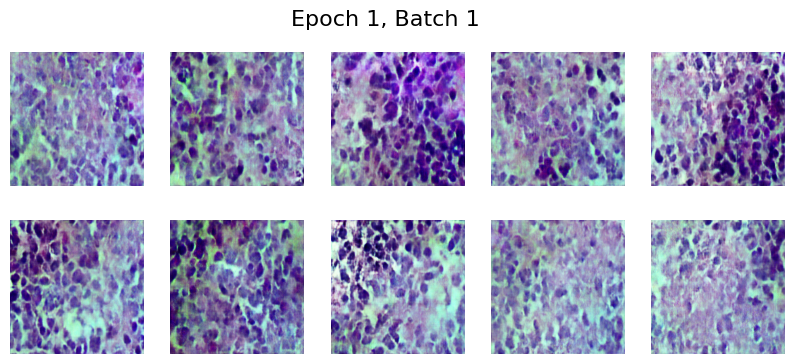

Epoch 1/10:  50%|█████     | 501/1000 [08:39<07:54,  1.05batch/s, D_Loss=-91.4, G_Loss=-194]

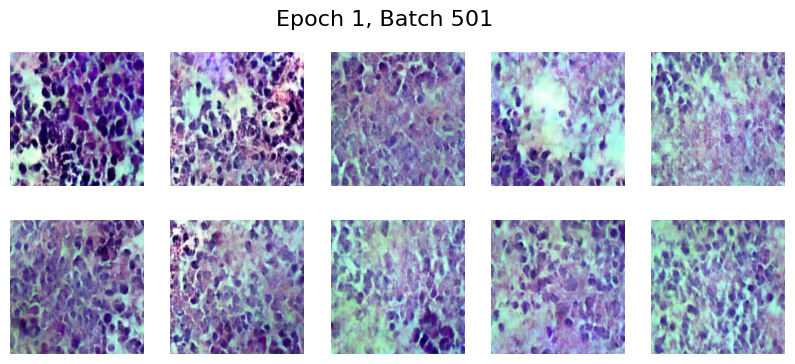

Epoch 1/10: 100%|██████████| 1000/1000 [16:35<00:00,  1.00batch/s, D_Loss=-114, G_Loss=-87.1]



Epoch 2/10


Epoch 2/10:   0%|          | 1/1000 [00:00<15:47,  1.05batch/s, D_Loss=-122, G_Loss=-200]

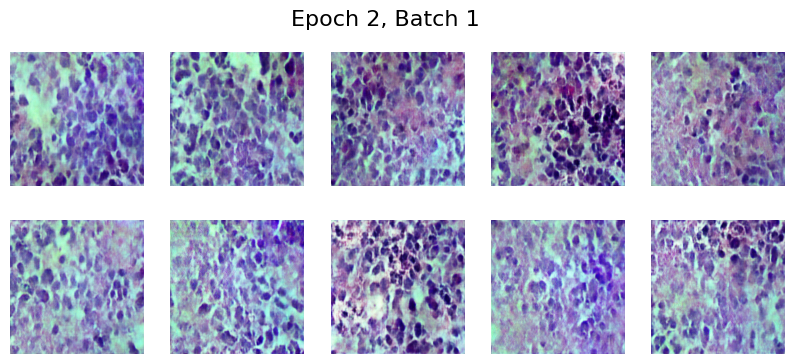

Epoch 2/10:  50%|█████     | 501/1000 [07:57<07:55,  1.05batch/s, D_Loss=-138, G_Loss=-52.2]

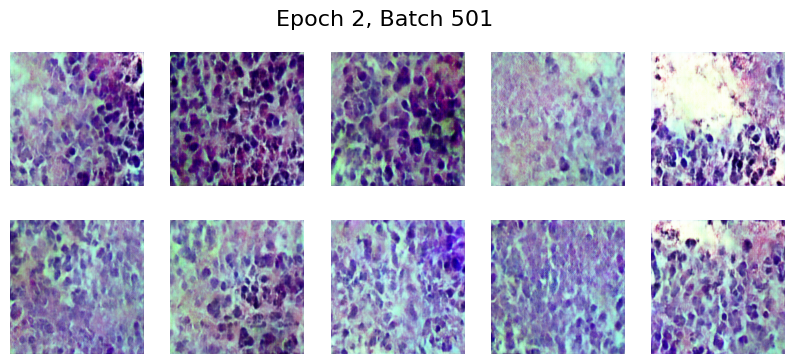

Epoch 2/10:  51%|█████▏    | 514/1000 [08:10<07:43,  1.05batch/s, D_Loss=-137, G_Loss=-180]


KeyboardInterrupt: 

In [ ]:
train(generator, discriminator, X_train, EPOCHS, STEPS_PER_EPOCH, d_steps=d_steps, gp_weight=gp_weight)


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Define the save paths, including the directories
generator_save_path = '/content/drive/MyDrive/W-gan/generator_weights1.weights.h5'
discriminator_save_path = '/content/drive/MyDrive/D-gan/discriminator_weights1.weights.h5'

# Create the directories if they don't exist
os.makedirs(os.path.dirname(generator_save_path), exist_ok=True)
os.makedirs(os.path.dirname(discriminator_save_path), exist_ok=True)

# Now save the weights
generator.save_weights(generator_save_path)
discriminator.save_weights(discriminator_save_path)

In [ ]:
# Assuming you saved the weights as in the provided code snippet
generator.load_weights('/content/drive/MyDrive/W-gan/generator_weights.weights.h5')
discriminator.load_weights('/content/drive/MyDrive/D-gan/discriminator_weights.weights.h5')

# Let's generate some images !

In [ ]:
noise = np.random.normal(0, 1, size=(100, NOISE_DIM))
sample_images(noise, (10,10), (24,20), save=True)

# Testing the Generated sample: Plotting the Distributions

<p style="font-size:20px">In this test, we compare the generated images with the real samples by plotting their distributions. If the distributions overlap, that indicates the generated samples are very close to the real ones
</p>

In [ ]:
generated_images = generator.predict(noise)
generated_images.shape

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,10))

sns.distplot(X_train, label='Real Images', hist=True, color='#fc0328', ax=axs)
sns.distplot(generated_images, label='Generated Images', hist=True, color='#0c06c7', ax=axs)

axs.legend(loc='upper right', prop={'size': 12})

plt.show()

# Some other testing methods

<p style="font-size:20px">
<ul>
    <li style="font-size:20px">Average Log-likelihood</li>
    <li style="font-size:20px">Inception Score</li>
    <li style="font-size:20px">Wasserstien Metric</li>
</ul>
</p>

# Conclusion

<p style="font-size:20px">
    As we can see from the plot, the distribution of Generated Images is approximately the same as that of the Real Images. From this we can conclude that the generated images are a true representative of the real ones, capturing most of the variations.
</p>

# References

<p style="font-size:20px">
<ul>
    <li style="font-size:20px"><a href="https://arxiv.org/abs/1406.2661">Generative Adversarial Networks</a> (2014)</li>
    <li style="font-size:20px"><a href="https://arxiv.org/abs/1606.03498">Improved Techniques for Training GANs</a> (2016)</li>
    <li style="font-size:20px"><a href="https://arxiv.org/abs/2108.03235">SMOTified-GAN for class imbalanced pattern classification problems</a> (2021)</li>
</ul>
</p>

![image.png](attachment:cd4bfd85-9bf6-45b7-b781-72321230eee7.png)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


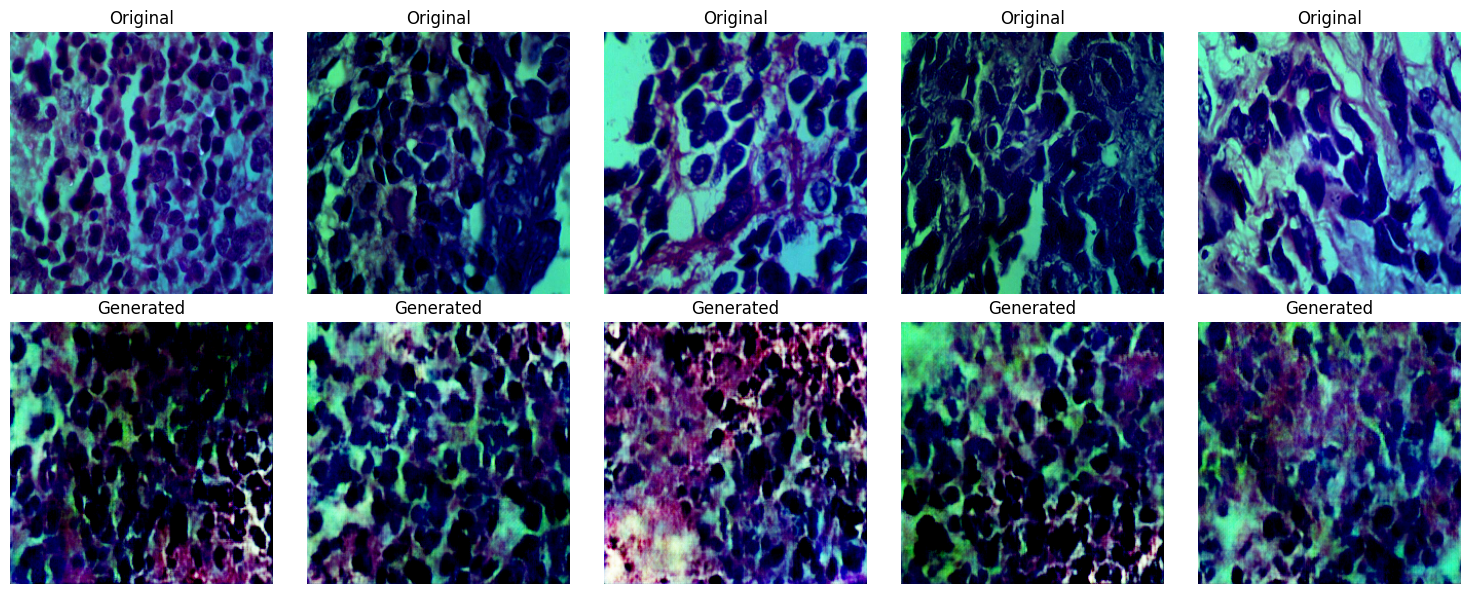

In [26]:
# prompt: Can you load the recently saved model and compare the results with the original dataset as generated and the dataset samples

# Assuming you saved the weights as in the provided code snippet
generator.load_weights('/content/drive/MyDrive/W-gan/generator_weights.weights.h5')
discriminator.load_weights('/content/drive/MyDrive/D-gan/discriminator_weights.weights.h5')

# Generate some images using the loaded model
noise = np.random.normal(0, 1, size=(100, NOISE_DIM))
generated_images = generator.predict(noise)

# Compare the generated images with the original dataset and samples
# You can use metrics like the Inception Score, Fréchet Inception Distance (FID), or visual inspection to assess the quality.

# Example: Visual comparison
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i in range(5):
  axs[0, i].imshow(X_train[i])
  axs[0, i].set_title("Original")
  axs[0, i].axis('off')

  axs[1, i].imshow(generated_images[i])
  axs[1, i].set_title("Generated")
  axs[1, i].axis('off')

plt.tight_layout()
plt.show()




In [25]:
# prompt: Can you load the recently saved model and compare the results with the original dataset as generated and calculate the Inception Score, Fréchet Inception Distance (FID)

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm
import numpy as np

def calculate_inception_score(images, splits=10):
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    scores = []
    for _ in range(splits):
        batch_size = len(images) // splits
        idx = np.random.choice(len(images), size=batch_size, replace=False)
        batch = images[idx]

        resized_batch = tf.image.resize(batch, (299, 299))
        processed_batch = preprocess_input(resized_batch.numpy())

        predictions = inception_model.predict(processed_batch)
        p_yx = np.exp(predictions) / np.sum(np.exp(predictions), axis=1, keepdims=True)

        p_y = np.mean(p_yx, axis=0)
        kl_divergence = np.mean(np.sum(p_yx * (np.log(p_yx + 1e-16) - np.log(p_y + 1e-16)), axis=1))
        scores.append(np.exp(kl_divergence))

    return np.mean(scores), np.std(scores)

def calculate_fid(real_images, generated_images):
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    def calculate_activation_statistics(images):
        resized_images = tf.image.resize(images, (299, 299))
        processed_images = preprocess_input(resized_images.numpy())
        activations = inception_model.predict(processed_images)
        mu = np.mean(activations, axis=0)
        sigma = np.cov(activations, rowvar=False)
        return mu, sigma

    mu1, sigma1 = calculate_activation_statistics(real_images)
    mu2, sigma2 = calculate_activation_statistics(generated_images)

    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)

    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * 1e-6
        covmean = sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)

    return fid

# Assuming you have your real images (X_train) and generated images (generated_images)
# Replace with your actual data
# Example:
# noise = np.random.normal(0, 1, size=(100, NOISE_DIM))
# generated_images = generator.predict(noise)

# Calculate Inception Score
inception_score_mean, inception_score_std = calculate_inception_score(generated_images)
print(f"Inception Score: {inception_score_mean:.3f} +/- {inception_score_std:.3f}")


# Calculate FID
fid = calculate_fid(X_train, generated_images)
print(f"Fréchet Inception Distance (FID): {fid:.3f}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Inception Score: 1.005 +/- 0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
Fréchet Inception Distance (FID): 2.383
